# Pima Indian Diabetes Analysis

- Jim Haskin

- GA-Data Science
- Dec 2015

- 2/7/2016

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB

In [4]:
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import recall_score

In [5]:
# use fivethirtyeight style for all graphics
plt.style.use('fivethirtyeight')

In [6]:
# my learning curve
import sys
sys.path.insert(0, '/Users/jsmithson/education/functions')
from plot_learning_curve import plot_learning_curve
# Masons new improved learning curve
from sk_modelcurves.learning_curve import draw_learning_curve


In [7]:
f_size = 15

In [8]:
# Data Frame to hold results. To compare models after all are run
results = pd.DataFrame(index=['knn', 'logreg','nb', 'rf'], 
                       columns=['recall', 'precision', 'f1', 'accuracy','time','lc_com'])


# 1 - Describe the content of the dataset and its goals

## Investigate input module

In [9]:
!ls


README.md
haskin_hw2_pima_indian-Friday-5pm-semifinal.ipynb
haskin_hw2_pima_indian-Friday_good.ipynb
haskin_hw2_pima_indian-test.ipynb
haskin_hw2_pima_indian.ipynb
pima-indians-diabetes.data
pima-indians-diabetes.names.txt
pima_data_clean.csv
plot_learning_curve.py
plot_learning_curve.pyc
print3.py
print3.pyc
scratchpad.ipynb


In [10]:
!head -n 5 pima-indians-diabetes.data

6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


In [11]:
!tail -n 5 pima-indians-diabetes.data

10,101,76,48,180,32.9,0.171,63,0
2,122,70,27,0,36.8,0.340,27,0
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


  ## from the info file
  For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)
   
   
   - Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")

# 1 - Observations 
#### Describe the content of the dataset and its goals
- The file contains medical measurements for a population of Pima Indian women
- Constraints - All Female - At least 21yr. of age - Pima Indian Heritage
- It also contains a class variable for whether to subject has Diabetes
- We would like to find the model that best predicts Diabetes in the general population of Pima women.
#### From diabetes.org
- Prevalence: In 2012, 29.1 million Americans, or 9.3% of the population, had diabetes. 
- Prevalence in Seniors: The percentage of Americans age 65 and older remains high, at 25.9% 
- See more at: http://www.diabetes.org/diabetes-basics/statistics/#sthash.kYj7p7Sy.dpuf


# 2 - Describe the features and formulate a hypothesis on which might be relevant in predicting diabetes



In [12]:
features = ['n_pregnant', 'glucose', 'blood_pressure', 'skin_thick', 'insulin', 'bmi', 'pedigree', 'age']
class_title = ['test_positive']
titles = features + class_title
print titles

['n_pregnant', 'glucose', 'blood_pressure', 'skin_thick', 'insulin', 'bmi', 'pedigree', 'age', 'test_positive']


In [13]:
data = pd.read_csv('pima-indians-diabetes.data', names=titles)
data.head(3)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [14]:
data.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
n_pregnant        768 non-null int64
glucose           768 non-null int64
blood_pressure    768 non-null int64
skin_thick        768 non-null int64
insulin           768 non-null int64
bmi               768 non-null float64
pedigree          768 non-null float64
age               768 non-null int64
test_positive     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


# 2 - Observations
#### Describe the features and formulate a hypothesis on which might be relevant in predicting diabetes
Features are medical measurements for each subject, they fall into 3 general catagories
- Physical Condition : Blood Pressure, Skin Fold Thickness, Body Mass Index
- Body Changes over Time : Age, Number Times Pregnant
- Diabetes Related Measurements : Plasma Glucose, Insulin Levels, Diabetes Pedigree
- .......................................
- The Diabetic Features will probably be very important
- The Aging Features may be relevent if diabetes is more prevelent before the body fully develops or as the body wears down.
- The numbers sited above from diabetes.org show that diabetes rates are much higher in the older population.
- The general condition the subject is in will probably have a positive effect on the rate of disease. Poor health usually leads to disease susceptability. These features may be correlated, so they may be redundant
- .......................................
- All features are numeric. No catagoricals. Only the Pregnancies is a count. Most other features are integer, based on degree of measurement. (No half years, etc.)
- We have all 768 entries for each feature



# 3 - Describe the missing/NULL values. Decide if you should impute or drop them and justify your choice.

### 3 - Data Observations
- although we have entries for every feature, looking at the info we see minimums of 0 for ['glucose', 'blood_pressure', 'skin_thick', 'insulin', 'bmi'] 
- Highly unlikely. (Blood Pressure = 0 would imply the subject was dead) 
- Will assume we have missing data.
- NOTE - Zero is a valid entry for Number of Pregnancies, but may be a sensitive question that was just not answered. Will proceed assuming 0 is valid entry.

### 3 - Very High test_positve rate
- The rate of the test population was about 35%. Much higher than the 9.3% cited above. Even higher than the 26% for older Americans
- There must be something there.
- A good subject for further research.....

### See how many 0 entries we have

In [16]:
data.apply( lambda s : s.value_counts().get(0,0), axis=0)

n_pregnant        111
glucose             5
blood_pressure     35
skin_thick        227
insulin           374
bmi                11
pedigree            0
age                 0
test_positive     500
dtype: int64

### Replace 0s with Nan in appropriate fields

In [17]:
for field in ['glucose', 'blood_pressure', 'skin_thick', 'insulin', 'bmi']:
    data.loc[:,field]=data[field].where(data[field]!=0,np.nan)

In [18]:
# Check 0 count again
data.apply( lambda s : s.value_counts().get(0,0), axis=0)

n_pregnant        111
glucose             0
blood_pressure      0
skin_thick          0
insulin             0
bmi                 0
pedigree            0
age                 0
test_positive     500
dtype: int64

In [19]:
data.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Look at the counts and test positive rates for the different features

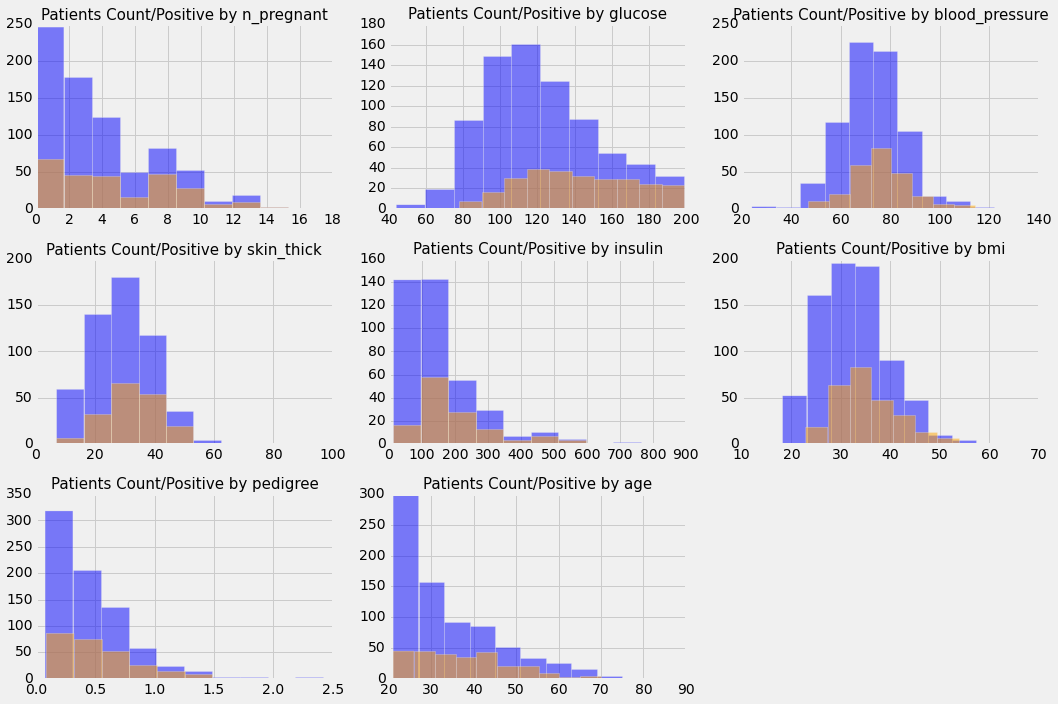

In [20]:
# Plot histogram of count and test positive counts by each feature
fig = plt.figure(figsize=(15,10))
positive_data = data[data['test_positive']==1]
for i, field in enumerate(features):
    plot_title = 'Patients Count/Positive by ' + str(field)
    ax = plt.subplot(3,3,i+1)
    ax.set_title(plot_title, fontsize=15)
    data[field].hist(ax=ax,bins=10, color='b', alpha=.5);
    positive_data[field].hist(ax=ax,bins=10, color='orange', alpha=.5);
plt.tight_layout();

### 3 - Observations from Plots
- Could have outliers at high end of insulin, and low end of blood_pressure
- Several features do not have many samples in the upper ranges. (Preg, insulin, pedigree, age)
- But the Positive rates are very high.
- Disturbingly, could mean that many in the population in the higher ranges have passed away from the disease.

In [21]:
data[data['insulin']>600]

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
13,1,189,60,23,846,30.1,0.398,59,1
228,4,197,70,39,744,36.7,2.329,31,0
247,0,165,90,33,680,52.3,0.427,23,0


#### 3 - High insulin records
- They look good otherwise.
- Could be black swan data
- since I believe insulin is important will leave in data set

In [22]:
data[data['blood_pressure']<40]

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
18,1,103,30,38,83,43.3,0.183,33,0
125,1,88,30,42,99,55.0,0.496,26,1
597,1,89,24,19,25,27.8,0.559,21,0
599,1,109,38,18,120,23.1,0.407,26,0


#### 3 - Low blood pressure records
- Diastolic Blood Pressure normal runs 40-160
- 30 and below is probably a bad reading
- Replace 3 low readings with NaN ...........     NOTE: This seems dangerous to replace with mean????

In [23]:
data.loc[:,'blood_pressure']=data['blood_pressure'].where(data['blood_pressure']>35,np.nan)

In [24]:
data.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,768.000000,763.000000,730.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.587671,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.073443,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,38.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Investigate Missing Data

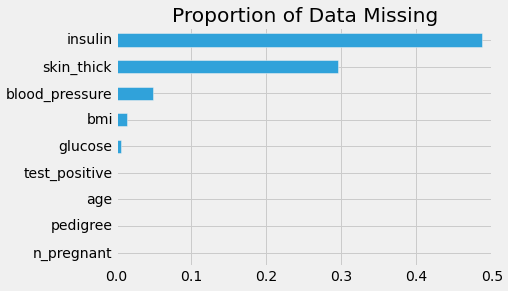

In [25]:
# visualize where data is missing
data.apply(lambda x: sum(x.isnull())*1.0 / len(x)).sort_values().plot(kind='barh', 
                                                                       title='Proportion of Data Missing')

### 3 - Missing data
- insulin - 376 = 49%
- skin_thick - 227 = 29%
- blood_pressure - 35 = 4.5%
- bmi - 11 = 1.4%
- glucose - 5 = 0.6%

### look at missing 'insulin' records

In [26]:
in_null = data.loc[data['insulin'].isnull(),:]
in_null.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,374.000000,370.000000,339.000000,147.000000,0,364.000000,374.000000,374.000000,374.000000
mean,4.433155,120.700000,74.439528,29.278912,NaN,31.793407,0.415340,35.796791,0.368984
std,3.437621,30.238604,11.979706,10.438195,NaN,6.763519,0.300547,12.729034,0.483176
min,0.000000,44.000000,44.000000,8.000000,NaN,18.200000,0.078000,21.000000,0.000000
25%,1.000000,100.250000,66.000000,22.000000,NaN,26.800000,0.209000,25.000000,0.000000
50%,4.000000,115.000000,74.000000,30.000000,NaN,31.200000,0.302500,32.000000,0.000000
75%,7.000000,138.000000,82.000000,35.500000,NaN,35.725000,0.553250,43.000000,1.000000
max,14.000000,199.000000,122.000000,99.000000,NaN,52.900000,1.893000,72.000000,1.000000


In [27]:
in_notnull = data.loc[data['insulin'].notnull(),:]
in_notnull.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,394.000000,393.000000,391.000000,394.000000,394.000000,393.000000,394.000000,394.000000,394.000000
mean,3.286802,122.615776,70.982097,29.106599,155.548223,33.072519,0.525543,30.814721,0.329949
std,3.209635,30.822276,11.938612,10.504273,118.775855,7.023947,0.350127,10.198971,0.470792
min,0.000000,56.000000,38.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.250000,28.400000,0.270250,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.000000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,36.750000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


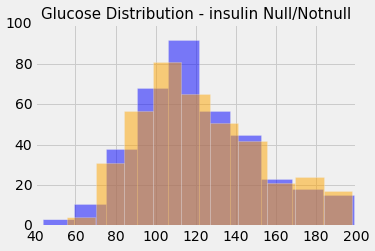

In [28]:
# Plot histogram looking at Glucose counts by null and not null insulin features
fig = plt.figure(figsize=(15,10))
plot_title = 'Glucose Distribution - insulin Null/Notnull'
ax = plt.subplot(3,3,i+1)
ax.set_title(plot_title, fontsize=15)
in_null['glucose'].hist(ax=ax,bins=10, color='b', alpha=.5);
in_notnull['glucose'].hist(ax=ax,bins=10, color='orange', alpha=.5);
plt.tight_layout();

### 3 - Missing insulin
- Feature means of both groups are not far apart.
- The glucose counts for the null and notnull are distributed closely. (Doesn't appear that the missing insulin records are grouped at either end.)
- Imputing with mean should be okay
- What to do with this feature will be a tough call. 

### look at missing 'skin_thick' records

In [29]:
data.loc[data['skin_thick'].isnull(),:].describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,227.000000,227.000000,194.000000,0,0,218.000000,227.000000,227.000000,227.000000
mean,4.638767,123.449339,75.025773,NaN,NaN,31.373853,0.393291,37.251101,0.387665
std,3.350062,29.572931,12.305454,NaN,NaN,6.952505,0.276871,13.062933,0.488294
min,0.000000,44.000000,48.000000,NaN,NaN,18.200000,0.078000,21.000000,0.000000
25%,2.000000,105.000000,66.000000,NaN,NaN,25.925000,0.203000,27.000000,0.000000
50%,4.000000,120.000000,74.500000,NaN,NaN,30.850000,0.282000,34.000000,0.000000
75%,7.000000,140.500000,82.000000,NaN,NaN,35.300000,0.536500,45.000000,1.000000
max,13.000000,197.000000,122.000000,NaN,NaN,52.900000,1.781000,72.000000,1.000000


In [30]:
data.loc[data['skin_thick'].notnull(),:].describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,541.000000,536.000000,536.000000,541.000000,394.000000,539.000000,541.000000,541.000000,541.000000
mean,3.512015,120.940299,71.705224,29.153420,155.548223,32.895733,0.504850,31.558226,0.332717
std,3.324759,30.931159,11.877051,10.476982,118.775855,6.871851,0.346639,10.743768,0.471622
min,0.000000,56.000000,38.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,22.000000,76.250000,27.850000,0.259000,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,125.000000,32.800000,0.417000,28.000000,0.000000
75%,5.000000,141.000000,80.000000,36.000000,190.000000,36.900000,0.660000,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 3 - Missing skin_thick
- Mean values very similar in both groups.
- 'insulin' also missing for the null group. (missing data seems to be from the same patients)
- probably safe to use mean.

In [31]:
data.loc[data['blood_pressure'].isnull(),:].describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,38.000000,38.000000,0,5.000000,3.000000,31.000000,38.000000,38.000000,38.000000
mean,3.421053,115.868421,NaN,30.400000,69.000000,33.090323,0.390342,30.394737,0.447368
std,3.568871,27.255717,NaN,9.710819,38.935845,8.904469,0.248285,9.581907,0.503897
min,0.000000,73.000000,NaN,19.000000,25.000000,19.600000,0.102000,21.000000,0.000000
25%,0.250000,94.500000,NaN,23.000000,54.000000,27.650000,0.193750,24.250000,0.000000
50%,2.000000,115.500000,NaN,30.000000,83.000000,30.000000,0.292000,28.000000,0.000000
75%,6.000000,131.750000,NaN,38.000000,91.000000,39.200000,0.566500,32.750000,1.000000
max,13.000000,183.000000,NaN,42.000000,99.000000,55.000000,0.933000,72.000000,1.000000


### 3 - Missing 'blood_pressure'
- Feature means of records are similar
- These records also missing blood_pressure and insulin

In [32]:
data.loc[data['bmi'].isnull(),:].describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,11.000000,11.000000,4.000000,2,1,0,11.000000,11.000000,11.000000
mean,3.909091,104.272727,79.250000,23,89,NaN,0.433273,30.454545,0.181818
std,3.505839,19.652435,13.400871,0,NaN,NaN,0.460162,15.945931,0.404520
min,0.000000,74.000000,64.000000,23,89,NaN,0.102000,21.000000,0.000000
25%,1.000000,89.000000,72.250000,23,89,NaN,0.210500,21.500000,0.000000
50%,3.000000,105.000000,78.500000,23,89,NaN,0.261000,24.000000,0.000000
75%,6.500000,116.500000,85.500000,23,89,NaN,0.438500,28.000000,0.000000
max,10.000000,136.000000,96.000000,23,89,NaN,1.731000,69.000000,1.000000


### 3 - Missing 'bmi'
- Feature means of records are similar
- These records also missing blood_pressure, skin_thick and insulin

In [33]:
data.loc[data['glucose'].isnull(),:].describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
count,5.00000,0,5.000000,5.000000,1,5.000000,5.000000,5.000000,5.000000
mean,2.80000,NaN,67.600000,29.600000,23,32.880000,0.380200,28.600000,0.400000
std,2.48998,NaN,12.033287,9.343447,NaN,7.033989,0.215527,9.607289,0.547723
min,1.00000,NaN,48.000000,20.000000,23,24.700000,0.140000,21.000000,0.000000
25%,1.00000,NaN,68.000000,20.000000,23,27.700000,0.299000,22.000000,0.000000
50%,1.00000,NaN,68.000000,32.000000,23,32.000000,0.346000,22.000000,0.000000
75%,5.00000,NaN,74.000000,35.000000,23,39.000000,0.389000,37.000000,1.000000
max,6.00000,NaN,80.000000,41.000000,23,41.000000,0.727000,41.000000,1.000000


### 3 - Missing 'glucose' 
- Similar means 
- only 5 records

### Check for highly correlated features

In [34]:
data.corr()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
n_pregnant,1.000000,0.128135,0.207519,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
glucose,0.128135,1.000000,0.215516,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
blood_pressure,0.207519,0.215516,1.000000,0.242259,0.082653,0.320058,-0.005455,0.330675,0.174853
skin_thick,0.100239,0.228043,0.242259,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
insulin,0.082171,0.581186,0.082653,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
bmi,0.021719,0.232771,0.320058,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
pedigree,-0.033523,0.137246,-0.005455,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
age,0.544341,0.267136,0.330675,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
test_positive,0.221898,0.494650,0.174853,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


### 3 -  High Correlations
FieldName|Corr|Option
---------|----|-----------
insulin/glucose | .58 - Missing many insuline readings | Maybe do without
skin_thinkness/bmi | .64 - Missing many skin_thinkness | Maybe do without



### Look at the Positive Ratio over each feature to get a sense of which featurea may be important

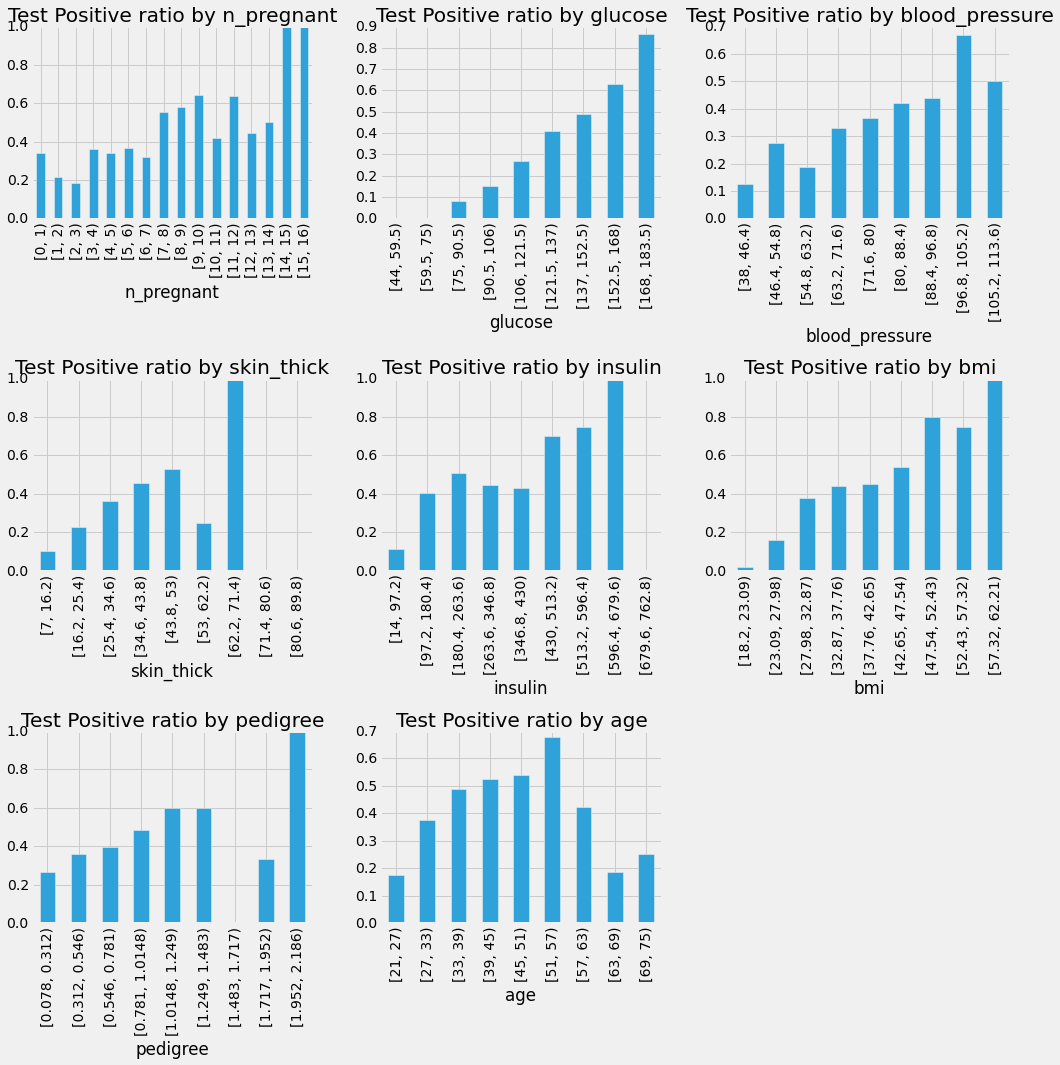

In [35]:
# plot the positive test ratio for each feature
fig = plt.figure(figsize=(15,15))
for i, field in enumerate(features):
    ax = plt.subplot(3,3,i+1)
    plot_title = 'Test Positive ratio by ' + str(field)
    high = data[field].max()
    low = data[field].min()
    step = (high-low)/10
    grouped = data.groupby(pd.cut(data[field], np.arange(low, high, step), right=False))
    positive_by_group = grouped.mean()
    positive_by_group['test_positive'].plot.bar(ax=ax, title= plot_title);
plt.tight_layout();

### 3 - Observations from plots
- Most features seem to have a positive correlation to testing positive. Several approch 100% at the high end
- Glucose is almost a straight line.
- Pedigree and Skin Thickness are pretty straight, but have a bin or two that don't fit.
- Age seems to have a bell shape distribution.

## Decide what to do with Nan
Possibilities
#### Drop all records with missing data
- Will lose 375 out of 768 records. almost 50%
- Probably not a great idea. Not enough data to train and test from.

#### Drop the fields with missing data
- The two fields that are missing the most data are 'insulin' and 'skin_thick'. Both are correlated  with other features.
- Dropping them may not effect accuracy and may reduce varience from too many correlated features. It would also spead up the testing and have fewer features to explain.

#### Replace missing data with mean
- Replacing with the mean values would allow us to keep all the features. May get more info out of them.
- Both have a high Standard Deviation. Could add to the varience. 

# 3 - Decision - Observations 
#### Describe the missing/NULL values. Decide if you should impute or drop them and justify your choice.

### Decision 
Field|Observations|Decision
-----|---------|--------
glucose | only 5 records, glucose probably very important feature, so records missing this value may not help much. | Drop the 5 records
bmi | 11 records, missing other fields, but have glucose. | Drop records.
blood_pressure | 35 records - so would like to keep. Means with and without are similar | Replace with mean.
skin_thick | 227 records - too many to drop, means similar, correlated 65% to bmi but not 'very' correlated. | Replace with mean
insulin | The hard one. Missing 50% so would like to drop. Insulin is very related to diabetes so would like to keep. 58% correlated with glucose. | Decision - Drop the field.
- But will run test with and without insulin field to check.

#### I did run the models with several versions of the data
- Dropping all records with missing data performed notiably worse.
- Ran with insulin feature removed, again with it back in and then with 3 halo features.
- Read further for results. Summary chart at bottem also.

In [36]:
# save a copy of original data
data_full = data.copy()
# make a version with the insulin field imputed
data_in = data.copy()   # use for alternative: keep insulin/thick and use mean values

### Replace the missing skin_thick and blood_pressure features with the mean value

In [37]:
#bmi_mean = data.describe().loc['mean']['bmi']
bp_mean = data.describe().loc['mean']['blood_pressure']
thick_mean = data.describe().loc['mean']['skin_thick']
#print bmi_mean, bp_mean, thick_mean
print bp_mean, thick_mean

72.5876712329 29.1534195933


In [38]:
data.loc[:,'blood_pressure'] = data['blood_pressure'].where(pd.notnull(data['blood_pressure']),bp_mean)
data.loc[:,'skin_thick'] = data['skin_thick'].where(pd.notnull(data['skin_thick']),thick_mean)
data.head(3)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
0,6,148,72,35.00000,NaN,33.6,0.627,50,1
1,1,85,66,29.00000,NaN,26.6,0.351,31,0
2,8,183,64,29.15342,NaN,23.3,0.672,32,1


### Make a version with the insulin field imputed for comparative test




In [39]:
data_in = data.copy()   # use for alternative: keep insulin/thick and use mean values
insulin_mean = data_in.describe().loc['mean']['insulin']
data_in.loc[:,'insulin'] = data_in['insulin'].where(pd.notnull(data_in['insulin']),insulin_mean)
data_in.head(3)


,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive
0,6,148,72,35.00000,155.548223,33.6,0.627,50,1
1,1,85,66,29.00000,155.548223,26.6,0.351,31,0
2,8,183,64,29.15342,155.548223,23.3,0.672,32,1


### Drop the insulin feature for initial run

In [40]:
data = data.drop(['insulin'], axis=1)
features = ['n_pregnant', 'glucose', 'blood_pressure', 'skin_thick', 'bmi', 'pedigree', 'age']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 8 columns):
n_pregnant        768 non-null int64
glucose           763 non-null float64
blood_pressure    768 non-null float64
skin_thick        768 non-null float64
bmi               757 non-null float64
pedigree          768 non-null float64
age               768 non-null int64
test_positive     768 non-null int64
dtypes: float64(5), int64(3)
memory usage: 54.0 KB


### Drop Nan - the few missing glucose records

In [41]:
data = data.dropna()
data_in = data_in.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752 entries, 0 to 767
Data columns (total 8 columns):
n_pregnant        752 non-null int64
glucose           752 non-null float64
blood_pressure    752 non-null float64
skin_thick        752 non-null float64
bmi               752 non-null float64
pedigree          752 non-null float64
age               752 non-null int64
test_positive     752 non-null int64
dtypes: float64(5), int64(3)
memory usage: 52.9 KB


# 4 - Come up with a benchmark for the minimum performance that an algorithm should have on this dataset



## Look at the diabetes Ratio

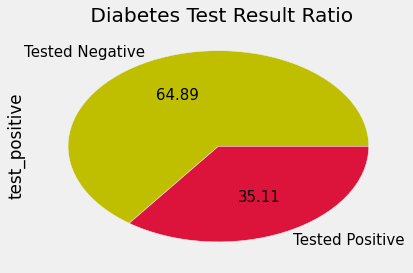

In [42]:
positive_count = data['test_positive'].value_counts()
positive_count.plot(kind='pie', labels=['Tested Negative','Tested Positive'],
                   colors=['y','crimson'], fontsize=f_size, autopct='%.2f',
                   title=' Diabetes Test Result Ratio');

## 4 - Observation
- Test Accuracy must be better than the 65% we could get from assuming everyone was negative.
- We are concerned with minimizing the False Negatives. (Missing that someone has diabetes). So we will use 'recall' as our scoring method.


In [43]:
scoring = 'recall'
#scoring = 'precision'
#scoring = 'f1'

### Scoring observations
- Also ran initial data through with precision and f1 scoring. 
- Highest score achieved was .76 for logreg tuned to precision. Was 11% higher than logreg for recall
- will run again with final model for comparesion

## 4.5 Prepare the data


### Add Halo Features
- will make a seperate data set with engineered features.
- After initial runs of Random Forest observed the highest Importance Score were glucose, bmi, and age.
- since they are one from each of my original feature catagories (diabetes, physical condition, aging) I created new features for all 3 combinations.

In [44]:
# begin with the data that has the means added in
#data_h = data.copy() # no insulin

# use data with insulin feature 
data_h = data_in.copy()

In [45]:
data_h['age_bmi'] = data_h.age * data_h.bmi
data_h['glu_age'] = data_h.age * data_h.glucose
data_h['glu_bmi'] = data_h.bmi * data_h.glucose

In [46]:
data_h.describe()

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,test_positive,age_bmi,glu_age,glu_bmi
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,3.851064,121.941489,72.585396,29.166816,155.812979,32.454654,0.473051,33.312500,0.351064,1082.939894,4155.748670,4006.858378
std,3.375189,30.601198,11.815549,8.852107,85.750988,6.928926,0.330108,11.709395,0.477621,436.547289,2078.847246,1480.170183
min,0.000000,44.000000,38.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000,382.200000,1232.000000,1100.000000
25%,1.000000,99.750000,64.000000,25.000000,120.000000,27.500000,0.244000,24.000000,0.000000,751.275000,2626.000000,2924.100000
50%,3.000000,117.000000,72.000000,29.153420,155.548223,32.300000,0.377000,29.000000,0.000000,993.800000,3510.000000,3773.450000
75%,6.000000,141.000000,80.000000,32.000000,155.548223,36.600000,0.627500,41.000000,1.000000,1357.200000,5200.000000,4841.775000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,2697.000000,12998.000000,10692.000000


### Write final clean data to file to be used in future

In [47]:
data_h.to_csv('pima_data_clean.csv', index=False)


### Break up data into training and test data

In [48]:
# Uncomment the data file to be run through the models

# The regular data (insulin dropped)
#data_y = data['test_positive']
#data_X = data.drop('test_positive', axis=1)

# Use data with insulin
#data_y = data_in['test_positive']
#data_X = data_in.drop('test_positive', axis=1)

# Use halo features
data_y = data_h['test_positive']
data_X = data_h.drop('test_positive', axis=1)

In [49]:
data_X.head(2)

,n_pregnant,glucose,blood_pressure,skin_thick,insulin,bmi,pedigree,age,age_bmi,glu_age,glu_bmi
0,6,148,72,35,155.548223,33.6,0.627,50,1680.0,7400,4972.8
1,1,85,66,29,155.548223,26.6,0.351,31,824.6,2635,2261.0


In [50]:
data_y.head(2)

0    1
1    0
Name: test_positive, dtype: int64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
                                                    test_size=0.2, random_state=7)

In [52]:
# 10 cross validation iterations with 20% test / 80% train
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

### Standardize data

In [53]:
# standardization: bring all of our features onto the same scale
stdsc = StandardScaler()
# transform our training features
X_train_std = stdsc.fit_transform(X_train)
# transform the testing features in the same way
X_test_std = stdsc.transform(X_test)

## Dummy Classifier

In [54]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train_std, y_train)
scores = cross_val_score(dummy_model, X_train_std, y_train, scoring=scoring, cv=cv)
print('CV Recall {}, Average Recall{}'.format(scores, scores.mean()))

CV Recall [ 0.23076923  0.44186047  0.34146341  0.4         0.52631579  0.41463415
  0.48387097  0.45652174  0.21568627  0.375     ], Average Recall0.388612202772


In [55]:
# class predictions (not predicted probabilities)
y_pred_class = dummy_model.predict(X_test_std)

In [56]:
recall_score = recall_score(y_test, y_pred_class)
recall_score

0.25862068965517243

In [57]:
acc_score = dummy_model.score(X_test_std, y_test)
acc_score

0.57615894039735094

In [58]:
precision_score = metrics.precision_score(y_test, y_pred_class)
precision_score

0.27777777777777779

In [59]:
f1_score = metrics.f1_score(y_test, y_pred_class)
f1_score

0.26785714285714285

In [60]:
# BEST knn time
time = %timeit -o dummy_model.predict(X_test_std)
print time

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 61.4 µs per loop


In [61]:
results.loc['dummy','recall'] = recall_score
results.loc['dummy','accuracy'] = acc_score
results.loc['dummy','precision'] = precision_score
results.loc['dummy','f1'] = f1_score
results.loc['dummy','time'] = time.best * 1000000

# 5 - What's the best performance you can get with kNN? Is kNN a good choice for this dataset?



In [62]:
# constructing classifier
# initialize our kNN
knn = KNeighborsClassifier()

In [63]:
# gridsearch for hyperparameters
parameters = {'n_neighbors': range(1,30), 'weights': ['uniform', 'distance'],
             'p': range(1,4)}
clf = GridSearchCV(knn, parameters, cv=cv, scoring=scoring)
clf.fit(X_train_std, y_train)

GridSearchCV(cv=ShuffleSplit(601, n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='recall', verbose=0)

In [64]:
# get the best performing combo
clf.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [65]:
#clf.grid_scores_

In [66]:
# Set up our best estimator
best_knn = clf.best_estimator_
print best_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=4, p=1, weights='distance')


/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


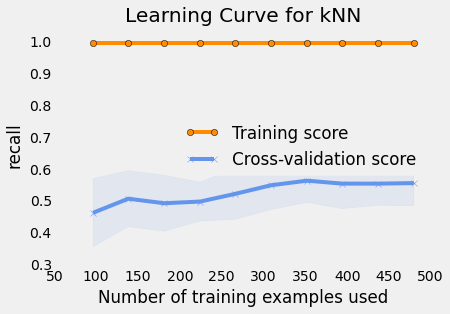

In [67]:
plot_learning_curve(best_knn, 'Learning Curve for kNN', X_train_std, y_train, 
                    scoring=scoring, cv=cv, ylim=(.3,1.05));



In [68]:
results.loc['knn','lc_com'] = 'slight varience, Traing up to 100%'

In [69]:
scores = cross_val_score(best_knn, X_train_std, y_train, cv=10, scoring=scoring)
print('CV score {}, Average score {}'.format(scores, scores.mean()))

CV score [ 0.61904762  0.66666667  0.47619048  0.47619048  0.57142857  0.47619048
  0.65        0.75        0.6         0.7       ], Average score 0.598571428571


In [70]:
# class predictions (not predicted probabilities)
y_pred_class = best_knn.predict(X_test_std)

In [71]:
# calculate classification recall score
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.65517241379310343

In [72]:
precision_score = metrics.precision_score(y_test, y_pred_class)
precision_score

0.6785714285714286

In [73]:
f1_score = metrics.f1_score(y_test, y_pred_class)
f1_score

0.66666666666666663

In [74]:
# So how accurate is our model
acc_score = best_knn.score(X_test_std, y_test)
acc_score

0.7483443708609272

In [75]:
# BEST knn time
time = %timeit -o best_knn.predict(X_test_std)
print time

100 loops, best of 3: 2.25 ms per loop


In [76]:
results.loc['knn','recall'] = recall_score
results.loc['knn','precision'] = precision_score
results.loc['knn','f1'] = f1_score
results.loc['knn','accuracy'] = acc_score
results.loc['knn','time'] = time.best * 1000000

# 5 - Observations - kNN
What's the best performance you can get with kNN? Is kNN a good choice for this dataset?






First run - removing insulin
- recall .48
- poor scores on train and test. High Bias
- noticable variance

Second run - imputing insulin
- recall .60
- better scores on train and test
- less variance

Third run - add 3 halo features
- recall .655
- even better scores on train and test
- less variance

Slow running time on all runs

### See final observations below

# 6 - What's the best performance you can get with Logistic Regression? Is LR a good choice for this dataset?





In [77]:
logreg = LogisticRegression()

In [80]:
# Tune Parameters using Gridsearch
parameters = {'C': np.linspace(0.01,.05,20), 'penalty': ['l1', 'l2']}
#parameters = {'penalty': ['l1', 'l2']}
clf = GridSearchCV(logreg, parameters, cv=cv, scoring=scoring)
clf.fit(X_train_std, y_train)

GridSearchCV(cv=ShuffleSplit(601, n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.01   ,  0.01211,  0.01421,  0.01632,  0.01842,  0.02053,
        0.02263,  0.02474,  0.02684,  0.02895,  0.03105,  0.03316,
        0.03526,  0.03737,  0.03947,  0.04158,  0.04368,  0.04579,
        0.04789,  0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='recall', verbose=0)

In [81]:
clf.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [82]:
clf.grid_scores_

[mean: 0.67620, std: 0.06742, params: {'penalty': 'l1', 'C': 0.01},
 mean: 0.57105, std: 0.08045, params: {'penalty': 'l2', 'C': 0.01},
 mean: 0.67390, std: 0.06429, params: {'penalty': 'l1', 'C': 0.012105263157894737},
 mean: 0.56438, std: 0.08002, params: {'penalty': 'l2', 'C': 0.012105263157894737},
 mean: 0.62522, std: 0.06521, params: {'penalty': 'l1', 'C': 0.014210526315789474},
 mean: 0.55962, std: 0.07675, params: {'penalty': 'l2', 'C': 0.014210526315789474},
 mean: 0.57756, std: 0.07784, params: {'penalty': 'l1', 'C': 0.016315789473684211},
 mean: 0.55479, std: 0.07244, params: {'penalty': 'l2', 'C': 0.016315789473684211},
 mean: 0.55557, std: 0.08282, params: {'penalty': 'l1', 'C': 0.018421052631578949},
 mean: 0.55247, std: 0.06963, params: {'penalty': 'l2', 'C': 0.018421052631578949},
 mean: 0.54373, std: 0.07934, params: {'penalty': 'l1', 'C': 0.020526315789473684},
 mean: 0.54983, std: 0.06907, params: {'penalty': 'l2', 'C': 0.020526315789473684},
 mean: 0.53557, std: 0.0

In [84]:
#best_logreg = clf.best_estimator_

In [85]:
best_logreg = LogisticRegression(C=.05, penalty='l1')

In [86]:
# Run model with BEST Coefficients
best_logreg.fit(X_train_std, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [87]:
# coefficients close to 0 aren't very helpful
pd.DataFrame({'features': X_test.columns, 'coefficients': best_logreg.coef_[0]})

,coefficients,features
0,0.195132,n_pregnant
1,0.374975,glucose
2,0.000000,blood_pressure
3,0.000000,skin_thick
4,0.000000,insulin
5,0.000000,bmi
6,0.083055,pedigree
7,0.000000,age
8,0.115696,age_bmi
9,0.000000,glu_age


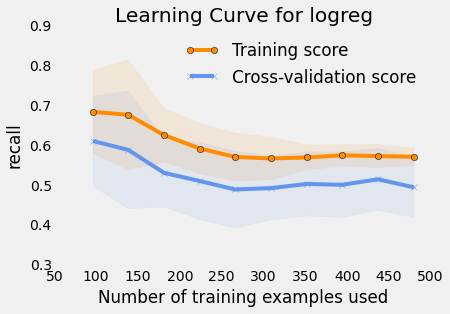

In [88]:
plot_learning_curve(best_logreg, 'Learning Curve for logreg', X_train_std, y_train, cv=cv, scoring=scoring);

In [89]:
results.loc['logreg','lc_com'] = 'low variance. score ~65. 5% gap'

In [90]:
# class predictions (not predicted probabilities)
y_pred_class = best_logreg.predict(X_test_std)

In [91]:
# calculate classification accuracy
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.60344827586206895

In [92]:
precision_score = metrics.precision_score(y_test, y_pred_class)
precision_score

0.79545454545454541

In [93]:
f1_score = metrics.f1_score(y_test, y_pred_class)
f1_score

0.68627450980392146

In [94]:
# So how accurate is our model?
acc_score = best_logreg.score(X_test_std, y_test)
acc_score

0.78807947019867552

In [95]:
# BEST logreg time
time = %timeit -o best_logreg.predict(X_test_std)

The slowest run took 4.38 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 30.6 µs per loop


In [96]:
results.loc['logreg','recall'] = recall_score
results.loc['logreg','precision'] = precision_score
results.loc['logreg','f1'] = f1_score
results.loc['logreg','accuracy'] = acc_score
results.loc['logreg','time'] = time.best * 1000000

# 6 - Observations - LogReg
What's the best performance you can get with Logistic Regression? Is LR a good choice for this dataset?





First run - removing insulin
- recall .655
- poor scores on train and test. High Bias
- low variance

Second run - imputing insulin
- recall .655
- similar performance

Third run - add 3 halo features
- recall .81
- better scores on train and test
- less variance

Fast running time on all 3 runs

### See final observations below

# 7 - What's the best performance you can get with Naive Bayes? Is NB a good choice for this dataset?

In [131]:
#parameters = {'alpha': np.linspace(1e-4, 1, 10)}
#nbayesM = MultinomialNB()
#clf = GridSearchCV(nbayesM, parameters, cv=cv, scoring=scoring)
#clf.fit(X_train, y_train)

In [132]:
# Gaussian Tune parms with grid search
#  ????? parameters = {'alpha': np.linspace(1e-4, 1, 10)}
nbayes = GaussianNB()
#clf = GridSearchCV(nbayes, parameters, cv=cv)
#clf.fit(X_train, y_train)

In [133]:
#clf.best_params_

In [134]:
#clf.best_score_

In [135]:
# Get best Estimator
#best_nb = clf.best_estimator_
best_nb = nbayes
best_nb.fit(X_train, y_train)

GaussianNB()

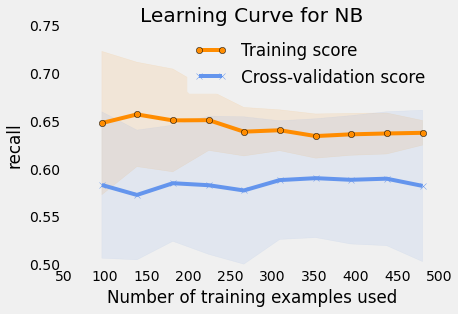

In [136]:
# Look at Learning Curve
plot_learning_curve(best_nb, 'Learning Curve for NB', X_train, y_train, cv=cv, scoring=scoring);

In [137]:
results.loc['nb','lc_com'] = 'low variance. score ~60. 5pt gap between train/test'

In [138]:
# Evaluate the decision tree using cross-validation; use recall as the evaluation metric.
scores = cross_val_score(best_nb, X_train, y_train, scoring=scoring, cv=5)
print('CV score {}, Average score {}'.format(scores, scores.mean()))

CV score [ 0.66666667  0.58536585  0.6097561   0.53658537  0.70731707], Average score 0.621138211382


In [139]:
# class predictions 
y_pred_class = best_nb.predict(X_test)

In [140]:
# calculate classification recall
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.72413793103448276

In [141]:
precision_score = metrics.precision_score(y_test, y_pred_class)
precision_score

0.66666666666666663

In [142]:
f1_score = metrics.f1_score(y_test, y_pred_class)
f1_score

0.69421487603305787

In [143]:
# Get accuracy score for Test Data
acc_score = best_nb.score(X_test, y_test)
acc_score

0.75496688741721851

In [144]:
# BEST nb time
time = %timeit -o best_nb.predict(X_test)

10000 loops, best of 3: 150 µs per loop


In [145]:
results.loc['nb','recall'] = recall_score
results.loc['nb','accuracy'] = acc_score
results.loc['nb','precision'] = precision_score
results.loc['nb','f1'] = f1_score
results.loc['nb','time'] = time.best * 1000000

# 7 - Observations - Naive Bayes
What's the best performance you can get with Naive Bayes? Is NB a good choice for this dataset?

First run - removing insulin
- recall .60
- poor scores on train and test. High Bias
- low variance

Second run - imputing insulin
- recall .568
- worse performance

Third run - add 3 halo features
- recall .72
- better scores on train and test
- low variance

Fast running time on all 3 runs

### See final observations below

# 8 - What's the best performance you can get with Random Forest? Is RF a good choice for this dataset?





In [112]:
rf = RandomForestClassifier()


In [113]:
#for n_trees in range(1, 200, 10):
#    model = RandomForestClassifier(n_estimators = n_trees)
#    model.fit(X_train_std, y_train)
#    scores = cross_val_score(model, X_train_std, y_train, scoring=scoring)
#    print('n_trees {}, CV score {}, Average score {}'.format(n_trees, scores, scores.mean()))

In [114]:
parameters = {'n_estimators': range(1, 200, 10)}
clf = GridSearchCV(rf, parameters, cv=cv)
clf.fit(X_train, y_train)
clf.best_params_


{'n_estimators': 191}

In [115]:
best_rf = clf.best_estimator_

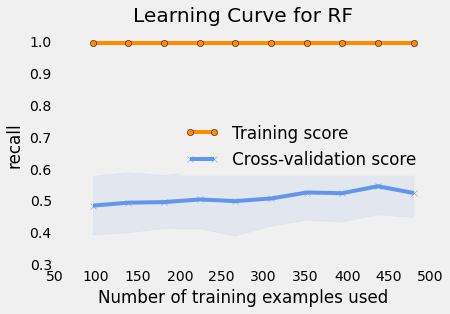

In [116]:
# Look at Learning Curve
plot_learning_curve(best_rf, 'Learning Curve for RF', X_train, y_train, cv=cv, 
                    ylim=(.3,1.05), scoring=scoring);

In [117]:
results.loc['rf','lc_com'] = 'very slight variance.'

In [118]:
# Evaluate the decision tree using cross-validation; use recall as the evaluation metric.
scores = cross_val_score(best_rf, X_train, y_train, scoring=scoring, cv=5)
print('CV score {}, Average score {}'.format(scores, scores.mean()))

CV score [ 0.5952381   0.53658537  0.46341463  0.53658537  0.73170732], Average score 0.572706155633


In [119]:
# class predictions 
y_pred_class = best_rf.predict(X_test)

In [120]:
# calculate classification recall
recall_score = metrics.recall_score(y_test, y_pred_class)
recall_score

0.60344827586206895

In [121]:
precision_score = metrics.precision_score(y_test, y_pred_class)
precision_score

0.72916666666666663

In [122]:
f1_score = metrics.f1_score(y_test, y_pred_class)
f1_score

0.66037735849056611

In [123]:
# Get accuracy score for Test Data
acc_score = best_rf.score(X_test, y_test)
acc_score

0.76158940397350994

In [124]:
# BEST rf time
time = %timeit -o best_rf.predict(X_test)

100 loops, best of 3: 10.1 ms per loop


In [125]:
results.loc['rf','recall'] = recall_score
results.loc['rf','accuracy'] = acc_score
results.loc['rf','precision'] = precision_score
results.loc['rf','f1'] = f1_score
results.loc['rf','time'] = time.best * 1000000

In [126]:
features = data_X.columns
feature_importances = best_rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
10,glu_bmi,0.175924
9,glu_age,0.146526
1,glucose,0.127444
8,age_bmi,0.101794
6,pedigree,0.089644
5,bmi,0.088933
7,age,0.062308
4,insulin,0.056503
3,skin_thick,0.051314
2,blood_pressure,0.051175


# 8 - Observations - Random Forest
What's the best performance you can get with Random Forest? Is RF a good choice for this dataset?





First run - removing insulin
- recall .54
- poor scores on train and test. High Bias
- slight variance
- training scores 100%

Second run - imputing insulin
- recall .55

Third run - add 3 halo features
- recall .56
- low variance

Very slow running time on all 3 runs

### See final observations below

# 9 - If you could only choose one, which classifer from the above that you already ran is best? How do you define best? (hint: could be prediction accuracy, running time, interpretability, etc)



# 9 - Observations
- Removing or imputing the missing insulin data had only a small effect on most models. (larger on kNN)
- Adding three halo features improved most of the models. (RF not much)
- The best performing model is the logistical regression. It had the highest recall score and ran the fastest.
- That would be my choice for further developement.

### Final Score
- 81% Recall score on a diabetes screening does not seem very good. We are missing 1/5 of the people who have the disease.
- Would like to do better.
- Can try adding more halo features.




# To ask mason and Lema
- Not sure about the way I used Gaussian Naive Bayes. No parms to tune.
- C score in Logistic Regression. Could not get a number that wasn't the lowest one I put in. Doesn't make me think I'm doing it right.
- Recall scoring - still confused about what a dummy model would be for this. (So I have something to beat.) A dummy would predict all negatives and 0 positives. If recall = TP/(TP+FN) it will always be 0.

In [147]:
results

,recall,precision,f1,accuracy,time,lc_com
knn,0.655172,0.678571,0.666667,0.748344,2246.22,"slight varience, Traing up to 100%"
logreg,0.603448,0.795455,0.686275,0.788079,30.5607,low variance. score ~65. 5% gap
nb,0.724138,0.666667,0.694215,0.754967,150.241,low variance. score ~60. 5pt gap between train...
rf,0.603448,0.729167,0.660377,0.761589,10072.3,very slight variance.
dummy,0.258621,0.277778,0.267857,0.576159,61.4105,NaN


### Historical Runs


Original run(no insulin)|model|recall|precision|f1|accuracy|time|LC comments
------------|-----|------|---------|--|--------|----|-----------
Tuning-Recall|knn	|0.482759	|0.651163	|0.554455	|0.701987	|12698	|CV still climbing, low scores for both train/test
|logreg	|0.655172	|0.655172	|0.655172	|0.735099	|32.4147	|low variance. score ~60
|nb	|0.603448	|0.686275	|0.642202	|0.609272	|97.5965	|low variance. score ~60. 10pt gap between trai...
|rf	|0.543438	|0.755556	|0.660194	|0.543438	|6194.16	|very slight variance.

2nd run add back insulin|model|recall|precision|f1|accuracy|time|LC comments
------------|-----|------|---------|--|--------|----|-----------
add back insulin|knn	|0.603448	|0.673077	|0.636364	|0.735099	|2263.86	|CV still climbing, low scores for both train/test
Tuning-Recall|logreg	|0.655172	|0.655172	|0.655172	|0.735099	|33.9839	|low variance. score ~60. 10pt.gap
|nb	|0.568966	|0.673469	|0.616822	|0.609272	|99.0775	|low variance. score ~60. 10pt gap between trai...
|rf	|0.558072	|0.717391	|0.634615	|0.558072	|10111	|very slight variance.

3nd run add back insulin|model|recall|precision|f1|accuracy|time|LC comments
------------|-----|------|---------|--|--------|----|-----------
add 3 halos|knn	|0.655172	|0.678571	|0.666667	|0.748344	|2450.51	|slight varience, Traing up to 100%
Tuning-recall|logreg	|0.810345	|0.671429	|0.734375	|0.774834	|33.3404	|low variance. score ~65. 5% gap
|nb	|0.724138	|0.666667	|0.694215	|0.615894	|104.664	|low variance. score ~60. 5pt gap between train...
|rf	|0.562718	|0.76087	|0.673077	|0.562718	|4892.99	|very slight variance.